#### Student Name:
#### Student ID:

# Assignment 8

#### Parallel CNN - RNN Model

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and a printout as a PDF.

# Let's try using a neural networks to classify audio genres


## Your Task:

In this Assignment we will explore the use of CNN-RNN for genre classification. You are provided some code as usual, and are asked to fill in missing portions and perform some experiments. 

The main tasks are:
* specifying the parameters of the CNN model
* you are provided with the code of the RNN model
* conducting an experiment with CNN-RNN model
* visualizing the preformance of the CNN layers
* performing ablation study by comparing it to only CNN and only RNN model


### Import packages

In [ ]:
pip install keract

In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

import keract

### Define representation of genres

Each genre is assigned a number, since the neural network will output a number [not a word]. 

In [ ]:
dict_genres = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 
               'Instrumental': 4,'International': 5, 'Pop': 6, 'Rock': 7}


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


### Load the dataset 

The dataset can be found at https://drive.google.com/drive/folders/1ZtwC9ralBSs6wzP-IylX5uh1wD1YXLh9?usp=sharing

Instructions: you can manually download it to your computer, or use wget from a command line. \
If you are using colab, you can copy the files to your drive and then mount the drive using google colab drive command: \
from google.colab import drive \
drive.mount('/content/drive')

In [ ]:
npzfile = np.load('/PATH_TO_YOUR_DATASET_FOLDER/shuffled_train.npz')

X_train = npzfile['arr_0']   # Audio samples
y_train = npzfile['arr_1']   # Genre labels
print(X_train.shape, y_train.shape)

In [ ]:
npzfile = np.load('/PATH_TO_YOUR_DATASET_FOLDER/shuffled_valid.npz')

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


### Let's see what one data sample looks like:

Electronic


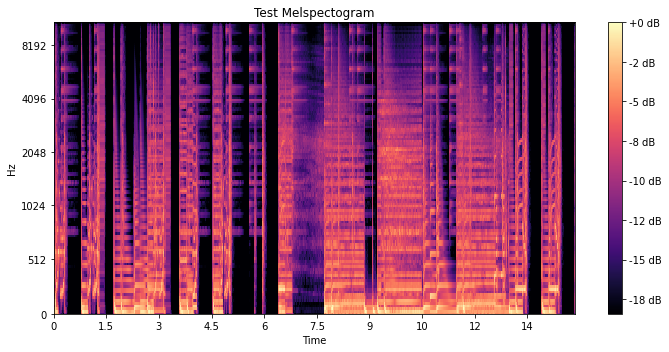

In [ ]:
one_arbitrary_sample = 0
spectogram = X_train[one_arbitrary_sample]
genre = np.argmax(y_train[one_arbitrary_sample])
print(reverse_map[genre])     # Reverse Map: Number to Label

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

##### Question 1 (20 points)

Create a few mel-spectograms samples for each genre. What are some visual differences between the genres? Are there similarities? What are some unique features for each genre that we might be able to use for classification?

``` Your response here ```

### Convolution Layer

A convolution is a kernel (a matrix of weights; also reffered to as a mask) that is applied across an image to extract spatial information by factoring each point's neighbors.  

Classical image processing uses custom kernels that can extract key features that can be used for problems like edge detection. Refer to this Wiki article for a few examples.
https://en.wikipedia.org/wiki/Kernel_(image_processing)

In deep learning, we build a model to learn more complicated kernels that can extract more specialized information.

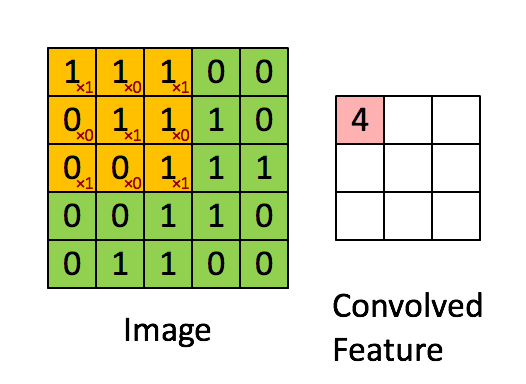

##### Question 2 (10 points)

Given a convolution layer with $f$ filters, ($k_x$ x $k_y$) kernel, and ($s_x$ x $s_y$) stride, what is the output dimension with/without padding (ie "valid" vs "same") on an ($n_x$ x $n_y$) image?

Please refer to the official keras documentation (https://keras.io/api/layers/convolution_layers/convolution2d/)

``` Your response here ```

### Pooling Layer

A pool is a very similar to a convolution layer. It is filter that is applied across the output of the convolution layer to reduce dimensionality and mitigate overfitting by summarizing the convolution results.

For this demonstration, we will be using max pooling.

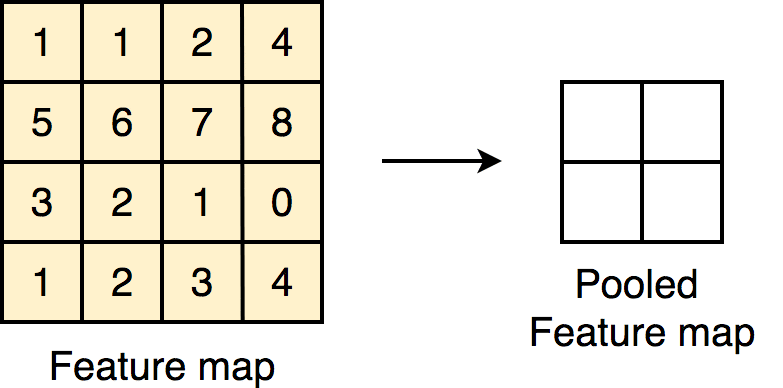

##### Question 3 (10 points)

Given a pooling layer ($p_x$ x $p_y$) pool and ($s_x$ x $s_y$) stride, what is the output dimension with/without padding (ie "valid" vs "same") on an ($n_x$ x $n_y$) image?

Please refer to the official keras documentation (https://keras.io/api/layers/pooling_layers/max_pooling2d/)

``` Your response here ```

### Now we will implement our model 
#### Parallel CNN - RNN Model

Since music has temporal features, it is obvious to use a RNN, but we saw from the melspectograms that there are also visual features that a CNN might learn. Our motivation is to try to combine both models through concatenation to extract both temporal and spatial features. 

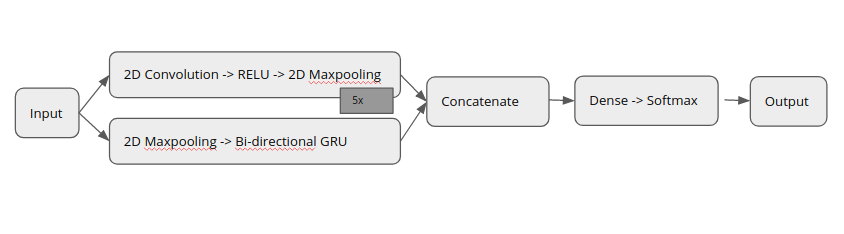

In [ ]:
# The number of possible predicted classes
num_classes = 8

# The number of features in a single data input (frequency components)
n_features = X_train.shape[2]

# The length of an input sample (in seconds)
n_time = X_train.shape[1]

In [ ]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks    
    conv_1 = Conv2D(filters=16, kernel_size=(3,1), strides=1,
                    padding='valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D((2,2))(conv_1)

    # Your Code Here
    # conv_2 = ...
    # pool_2 = ...
    
    # conv_3 = ...
    # pool_3 = ...
    
    # conv_4 = ...
    # pool_4 = ...
    
    # conv_5 = ...
    # pool_5 = ...

    flatten1 = Flatten()(pool_5)
    
    ### Recurrent Block
    lstm_count = 64
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D((4,2), name = 'pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = RMSprop(learning_rate=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    return model

##### Question 4 (30 points)

Fill in the missing code for the cell above and implement the four missing convolution layers interwoven with max pooling layers. When you run the commented-out code below, your output should match the image below. Use the first convolution and pooling layer as an example. 

All of the convolution layers should have the same kernel size, stride, padding, and activation function.

If you are stuck, this article should help:
https://towardsdatascience.com/how-to-calculate-the-number-of-parameters-in-keras-models-710683dae0ca



In [ ]:
n_frequency = 128
n_frames = 640
input_shape = (n_frames, n_frequency, 1)
model_input = Input(input_shape, name='input')
model = conv_recurrent_model_build(model_input)

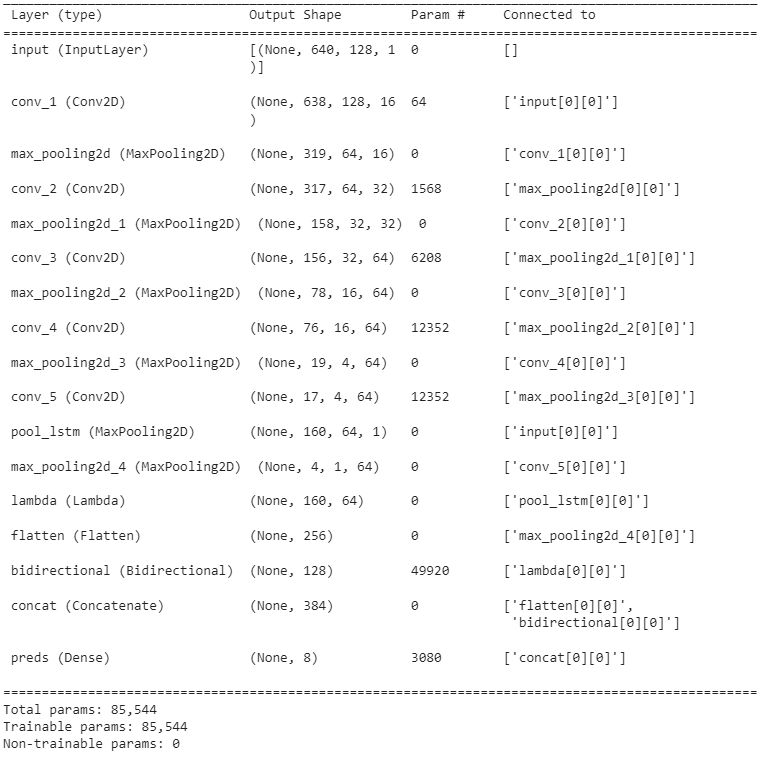

Hint: use print(model.summary()) to check if your model satisfies the requirements of the specifications above. 

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)  ### Step 1
    
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=64, epochs=5,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list) ### Step 2
    
    '''
    test_accuracy = model.eval(x_test, y_test)   ### Step 3
    '''

    return model, history

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
model, history = train_model(X_train, y_train, X_valid, y_valid)

### Results


In [ ]:
show_summary_stats(history)

In [ ]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

##### Question 5 (10 points)

Briefly describe, in a few sentences, the training results. Does the model perform well? What can we learn from the train and test loss curves? Is the model overfitted? What do the metrics tell us?

*Note that you can increase the number of epochs to get a better picture of the models performance


``` Your response here ```

### Visualizing the Model

In [ ]:
one_arbitrary_sample = 0
sample = X_valid[one_arbitrary_sample:one_arbitrary_sample+1]
genre = np.argmax(y_valid[one_arbitrary_sample])
print(genre)
activations = keract.get_activations(model, sample, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
keract.display_activations(activations, cmap=None, save=False, data_format='channels_last', fig_size=(20, 10))

##### Question 6 (20 points)
Visualize the activation layers for the CNN using the code above and try a few samples for each genre. Are there any clear features? Are any of the features similar to the features you expected at the start? Are there similar or different features across genres?

``` Your response here ```